In [62]:
import cv2
import numpy as np
from scipy.interpolate import griddata, interp2d
from scipy import ndimage
import sys
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import numpy as np
import matplotlib.lines as mlines
import matplotlib.pylab as plt


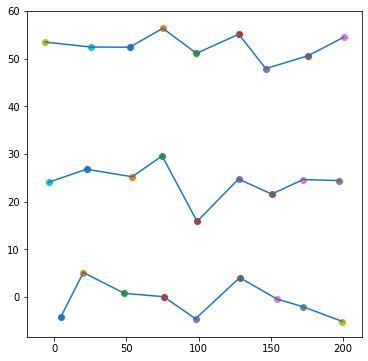

(array([[-0.15603402, 51.15968841],
       [-0.19299174, 52.12896807]]), array([[115.90478399,  99.82599827],
       [231.15053902, 200.40814769]]))


/home/taylor/anaconda3/envs/hwr5/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=7,8 m=27 fp=74.316015 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/taylor/anaconda3/envs/hwr5/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=6,9 m=27 fp=45.122745 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [87]:
def get_test_image():
    input_image = "data/prepare_IAM_Lines/lines/m04/m04-061/m04-061-02.png"
    input_image = "../data/sample_offline/a05-039-00.png"
    #input_image = "data/sample_online/0_6cfd6616717146a687391b52621340c1.tif"
    img = cv2.imread(input_image, 0)
    plot(img, "Original image")
    return img

def plot_grid(h,w,source):
    grid_img = np.zeros([h,w])+255
    if True:
        if len(grid_img.shape) == 2 or grid_img.shape[2]==1: # if already grayscale
            color = 0
        else:
            color = np.array([0,0,255])
        for s in source:
            grid_img[int(s[0]):int(s[0])+1,:] = color
            grid_img[:,int(s[1]):int(s[1])+1] = color
            
    plot(grid_img)
    
def overlay_grid(h,w,source):
    grid_img = np.zeros([h,w])+255
    #    plt.imshow(img, cmap="gray")

    previous = None

    fig, ax = plt.subplots()
    fig.set_size_inches(6,6)          # Make graph square

    # Swap to make it X,Y
    source = np.c_[source[:,1],source[:,0]]

    for current in source:          
        ax.scatter(current[0], current[1])
        if previous is None or previous[0] > current[0]:
            previous = current
            continue
        l = mlines.Line2D([previous[0],current[0]], [previous[1],current[1]])
        ax.add_line(l)
        previous = current

    plt.show()
    
def warp_image(img, random_state=None, **kwargs):
    if random_state is None:
        random_state = np.random.RandomState()

    w_mesh_interval = kwargs.get('w_mesh_interval', 25)
    w_mesh_std = kwargs.get('w_mesh_std', 3.0)

    h_mesh_interval = kwargs.get('h_mesh_interval', 25)
    h_mesh_std = kwargs.get('h_mesh_std', 3.0)

    interpolation_method = kwargs.get('interpolation', 'linear')

    h = np.max(img[:,0])
    w = np.max(img[:,1])
    
    if kwargs.get("fit_interval_to_image", True):
        # Change interval so it fits the image size
        w_ratio = w / float(w_mesh_interval)
        h_ratio = h / float(h_mesh_interval)

        w_ratio = max(1, round(w_ratio))
        h_ratio = max(1, round(h_ratio))

        w_mesh_interval = w / w_ratio
        h_mesh_interval = h / h_ratio
        ############################################

    # Get control points
    source = np.mgrid[0:h+h_mesh_interval:h_mesh_interval, 0:w+w_mesh_interval:w_mesh_interval]
    source = source.transpose(1,2,0).reshape(-1,2)


    # Perturb source control points
    destination = source.copy()
    source_shape = source.shape[:1]
    destination[:,0] = destination[:,0] + random_state.normal(0.0, h_mesh_std, size=source_shape) # Y 
    destination[:,1] = destination[:,1] + random_state.normal(0.0, w_mesh_std, size=source_shape) # X
    
    #plot_grid(h,w,source)
    overlay_grid(h,w,destination)
    # Warp image
#     grid_x, grid_y = np.mgrid[0:h, 0:w]
#     grid_z = griddata(destination, source, (grid_x, grid_y), method=interpolation_method).astype(np.float32)
#     map_x = grid_z[:,:,1]
#     map_y = grid_z[:,:,0]
#     warped = cv2.remap(img, map_x, map_y, INTERPOLATION[interpolation_method], borderValue=(255,255,255))
    
    h_func = interp2d(source[:,0], source[:,1], destination[:,0])
    w_func = interp2d(source[:,0], source[:,1], destination[:,1])
    warped = h_func(img[:,0],img[:,1]), w_func(img[:,0],img[:,1])
    globals().update(locals())
    return warped

def plot(img, title="No Title"):
    plt.figure(dpi=400)
    plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.show()

INTERPOLATION = {
    "linear": cv2.INTER_LINEAR,
    "cubic": cv2.INTER_CUBIC
}

# class scipy.interpolate.interp2d(x, y, z, kind='linear', copy=True, bounds_error=False, fill_value=None)[source]
# x, y and z are arrays of values used to approximate some function f: z = f(x, y). This class returns a function whose call method uses spline interpolation to find the value of new points.



# img = get_test_image()
# new_img = warp_image(img)
# plot(new_img, "New Image")

new_img = warp_image(np.array([[50,100],[20,200]]))
print(new_img)

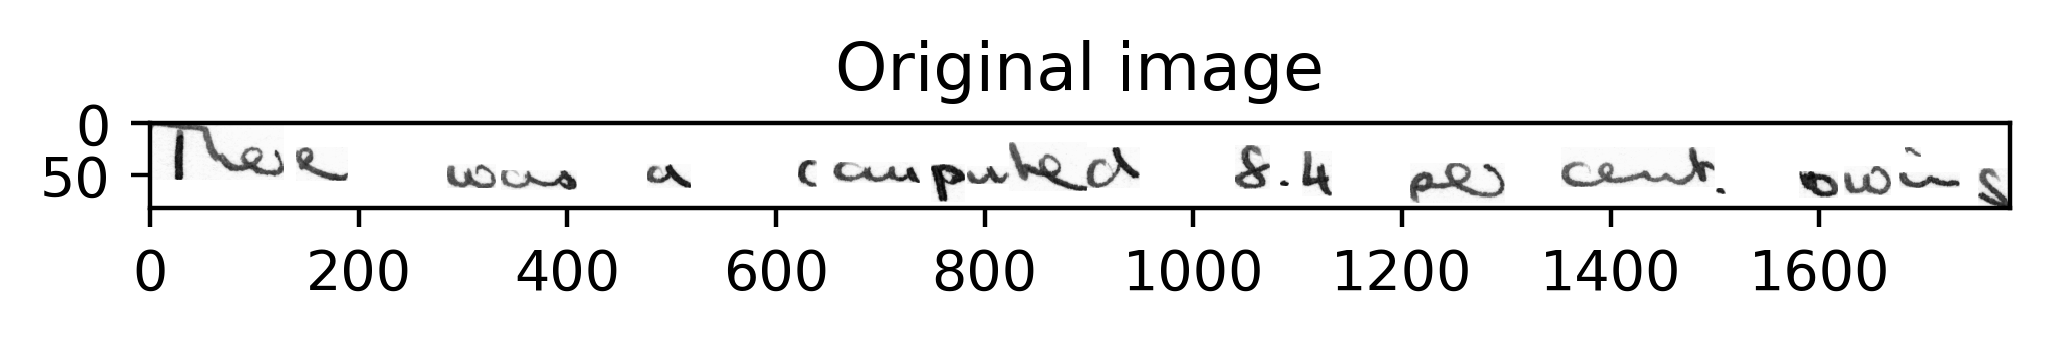

(82, 1783)


In [42]:
img = get_test_image()
print(img.shape)

In [26]:
print(source.shape)
print(source)

(288, 2)
[[   0.            0.        ]
 [   0.           25.11267606]
 [   0.           50.22535211]
 [   0.           75.33802817]
 [   0.          100.45070423]
 [   0.          125.56338028]
 [   0.          150.67605634]
 [   0.          175.78873239]
 [   0.          200.90140845]
 [   0.          226.01408451]
 [   0.          251.12676056]
 [   0.          276.23943662]
 [   0.          301.35211268]
 [   0.          326.46478873]
 [   0.          351.57746479]
 [   0.          376.69014085]
 [   0.          401.8028169 ]
 [   0.          426.91549296]
 [   0.          452.02816901]
 [   0.          477.14084507]
 [   0.          502.25352113]
 [   0.          527.36619718]
 [   0.          552.47887324]
 [   0.          577.5915493 ]
 [   0.          602.70422535]
 [   0.          627.81690141]
 [   0.          652.92957746]
 [   0.          678.04225352]
 [   0.          703.15492958]
 [   0.          728.26760563]
 [   0.          753.38028169]
 [   0.          778.49295775]

In [19]:
from scipy.interpolate import griddata
grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')


[[ 0.          0.        ]
 [ 0.         25.11267606]]
[[ 2.71860835 -1.00659896]
 [-3.07972478 25.00254619]]


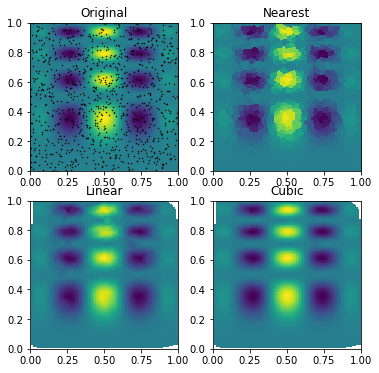

In [25]:
def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2
#on a grid in [0, 1]x[0, 1]

grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]
#but we only know its values at 1000 data points:

points = np.random.rand(1000, 2)
values = func(points[:,0], points[:,1])
#This can be done with griddata – below we try out all of the interpolation methods:

from scipy.interpolate import griddata
grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')
grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')
#One can see that the exact result is reproduced by all of the methods to some degree, but for this smooth function the piecewise cubic interpolant gives the best results:

import matplotlib.pyplot as plt
plt.subplot(221)
plt.imshow(func(grid_x, grid_y).T, extent=(0,1,0,1), origin='lower')
plt.plot(points[:,0], points[:,1], 'k.', ms=1)
plt.title('Original')
plt.subplot(222)
plt.imshow(grid_z0.T, extent=(0,1,0,1), origin='lower')
plt.title('Nearest')
plt.subplot(223)
plt.imshow(grid_z1.T, extent=(0,1,0,1), origin='lower')
plt.title('Linear')
plt.subplot(224)
plt.imshow(grid_z2.T, extent=(0,1,0,1), origin='lower')
plt.title('Cubic')
plt.gcf().set_size_inches(6, 6)
plt.show()

In [69]:
np.array([[1,2],[3,4]]).transpose()

array([[1, 3],
       [2, 4]])

In [78]:
print(source)

[[  0.   0.]
 [  0.  25.]
 [  0.  50.]
 [  0.  75.]
 [  0. 100.]
 [  0. 125.]
 [  0. 150.]
 [  0. 175.]
 [  0. 200.]
 [ 25.   0.]
 [ 25.  25.]
 [ 25.  50.]
 [ 25.  75.]
 [ 25. 100.]
 [ 25. 125.]
 [ 25. 150.]
 [ 25. 175.]
 [ 25. 200.]
 [ 50.   0.]
 [ 50.  25.]
 [ 50.  50.]
 [ 50.  75.]
 [ 50. 100.]
 [ 50. 125.]
 [ 50. 150.]
 [ 50. 175.]
 [ 50. 200.]]


In [79]:
source[source[:,1].argsort()]

array([[  0.,   0.],
       [ 50.,   0.],
       [ 25.,   0.],
       [  0.,  25.],
       [ 50.,  25.],
       [ 25.,  25.],
       [  0.,  50.],
       [ 50.,  50.],
       [ 25.,  50.],
       [  0.,  75.],
       [ 50.,  75.],
       [ 25.,  75.],
       [ 50., 100.],
       [ 25., 100.],
       [  0., 100.],
       [ 25., 125.],
       [  0., 125.],
       [ 50., 125.],
       [ 25., 150.],
       [  0., 150.],
       [ 50., 150.],
       [ 25., 175.],
       [  0., 175.],
       [ 50., 175.],
       [ 25., 200.],
       [  0., 200.],
       [ 50., 200.]])

In [80]:
print(source)

[[  0.   0.]
 [  0.  25.]
 [  0.  50.]
 [  0.  75.]
 [  0. 100.]
 [  0. 125.]
 [  0. 150.]
 [  0. 175.]
 [  0. 200.]
 [ 25.   0.]
 [ 25.  25.]
 [ 25.  50.]
 [ 25.  75.]
 [ 25. 100.]
 [ 25. 125.]
 [ 25. 150.]
 [ 25. 175.]
 [ 25. 200.]
 [ 50.   0.]
 [ 50.  25.]
 [ 50.  50.]
 [ 50.  75.]
 [ 50. 100.]
 [ 50. 125.]
 [ 50. 150.]
 [ 50. 175.]
 [ 50. 200.]]
